# PGA: Capstone Project - The Battle of Neighborhoods (Week 1)
## Data retrieval and exploration

**Importing the libraries for our tasks.**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from geopy.geocoders import Nominatim

import folium

import json
import requests
from pandas.io.json import json_normalize

### First data source: Scraping German cities wikipedia table

In [2]:
url='https://de.wikipedia.org/wiki/Liste_der_Gro%C3%9F-_und_Mittelst%C3%A4dte_in_Deutschland#Gro%C3%9F-_und_Mittelst%C3%A4dte_nach_Einwohnerzahl'

dfs = pd.read_html(url, attrs={'class': 'wikitable sortable zebra'})
gercities = dfs[1]
gercities.drop(['Rang', '1970', '1980', '1990', '2000', '2010'], axis=1, inplace=True)
gercities.rename(columns={"Name": "City", "2018": "Population", "Bundesland": "State"}, inplace=True)
print(gercities.shape)
print(gercities.dtypes)
gercities.head()

(700, 3)
City          object
Population    object
State         object
dtype: object


,City,Population,State
0,Berlin,3.644.826,Berlin
1,Hamburg,1.841.179,Hamburg
2,München,1.471.508,Bayern
3,Köln,1.085.664,Nordrhein-Westfalen
4,Frankfurt am Main,753.056,Hessen


**Conversion of datatypes, replacement of umlauts, dropping 'State' column.**

In [3]:
gercities.drop(['State'], axis=1, inplace=True)
gercities = gercities.convert_dtypes()
gercities['Population'] = gercities['Population'].str.replace('.', '').astype('int')
gercities['City'] = gercities['City'].str.replace('ü', 'ue')
gercities['City'] = gercities['City'].str.replace('ä', 'ae')
gercities['City'] = gercities['City'].str.replace('ö', 'oe')
gercities['City'] = gercities['City'].str.replace('ß', 'ss')
print(gercities.dtypes)
gercities.head()

City          string
Population     int64
dtype: object


,City,Population
0,Berlin,3644826
1,Hamburg,1841179
2,Muenchen,1471508
3,Koeln,1085664
4,Frankfurt am Main,753056


**Histogram plot by population.**

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f91f8d6a950>]],
      dtype=object)

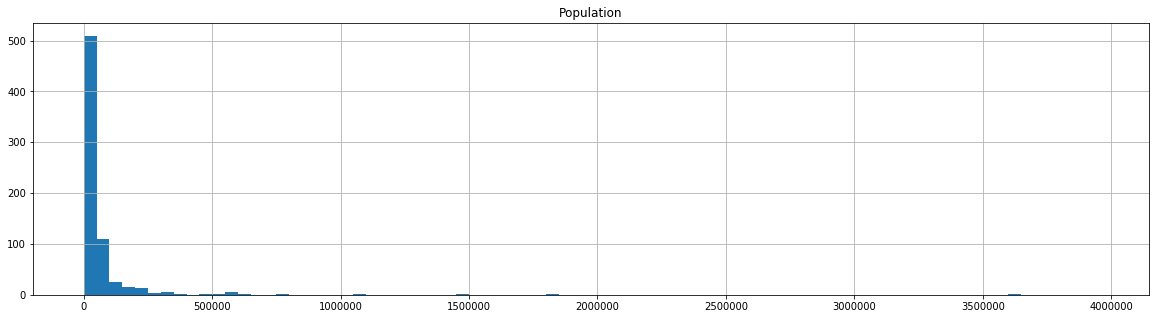

In [4]:
gercities.hist(column='Population', bins=np.arange(0,4000000,50000), figsize=(20, 5))

#### First observation: The majority of the cities have a population size below 100,000.
To reduce the time of the subsequent processing, these cities will be excluded from the dataframe.

In [5]:
gercities_red = gercities.loc[gercities['Population'] > 100000]
print(gercities_red.shape)
gercities_red.head()

(81, 2)


,City,Population
0,Berlin,3644826
1,Hamburg,1841179
2,Muenchen,1471508
3,Koeln,1085664
4,Frankfurt am Main,753056


We still have 81 cities left.

One city name is an irregular expression which would cause an error during retrieving the geolocation.

In [6]:
gercities_red.loc[29, 'City'] = 'Chemnitz'
gercities_red.loc[29, 'City']

/home/lars/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


'Chemnitz'

**Adding geolocation**

In [7]:
lat_list=[]
lng_list=[]

for row in range(gercities_red.shape[0]):
    geolocator = Nominatim(user_agent="coursera_capstone")
    location = geolocator.geocode('{}, Germany'.format(gercities_red.iloc[row, 0]))
    try:
        lat_list.append(location.latitude)
        lng_list.append(location.longitude)
    except AttributeError:
        lat_list.append('NaN')
        lng_list.append('NaN')
        continue

gercities_red.insert(loc=2, column='Latitude', value=lat_list)
gercities_red.insert(loc=3, column='Longitude', value=lng_list)
print(gercities_red.shape)
gercities_red.head()

(81, 4)


,City,Population,Latitude,Longitude
0,Berlin,3644826,52.517037,13.388860
1,Hamburg,1841179,53.543764,10.009913
2,Muenchen,1471508,48.137108,11.575382
3,Koeln,1085664,50.938361,6.959974
4,Frankfurt am Main,753056,50.110644,8.682092


**Mapping the locations of the cities**

In [8]:
# creating the map
map_ger_cities = folium.Map(location=[51.351, 10.454], zoom_start=5.5)

# add markers of citis to map
for lat, lng, city, pop in zip(gercities_red['Latitude'], gercities_red['Longitude'], gercities_red['City'], gercities_red['Population']):
    label = '{} (Population: {})'.format(city, pop)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_ger_cities)

map_ger_cities

### Second data source: Retrieving the venues for the cities from Foursquare.

In [9]:
CLIENT_ID = 'AOUOE4WYOQXAMZABF1J3HUQCXZ0GBEETIUCZDQOUYR0JGRQD' # your Foursquare ID
CLIENT_SECRET = 'MCY5M5APBTGR1J2QR20PQLZ2YVJBXRBG4OOML1ZHAMLHYCGR' # your Foursquare Secret
VERSION = '20200522' # Foursquare API version
LIMIT = 500

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: AOUOE4WYOQXAMZABF1J3HUQCXZ0GBEETIUCZDQOUYR0JGRQD
CLIENT_SECRET:MCY5M5APBTGR1J2QR20PQLZ2YVJBXRBG4OOML1ZHAMLHYCGR


In [10]:
def getNearbyVenues(cities, latitudes, longitudes, radius):
    
    venues_list=[]
    for city, lat, lng in zip(cities, latitudes, longitudes):
        print(city)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            city, 
            lat, 
            lng, 
            v['venue']['name'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City', 
                  'City Latitude', 
                  'City Longitude', 
                  'Venue', 
                  'Venue Category']
    
    return(nearby_venues)

Starting with a search radius of 5000m to ensure that we get the maximum count of venues for the cities.

In [11]:
gercities_venues = getNearbyVenues(cities=gercities_red['City'],
                                   latitudes=gercities_red['Latitude'],
                                   longitudes=gercities_red['Longitude'],
                                   radius=5000
                                  )

Berlin
Hamburg
Muenchen
Koeln
Frankfurt am Main
Stuttgart
Duesseldorf
Leipzig
Dortmund
Essen
Bremen
Dresden
Hannover
Nuernberg
Duisburg
Bochum
Wuppertal
Bielefeld
Bonn
Muenster
Karlsruhe
Mannheim
Augsburg
Wiesbaden
Moenchengladbach
Gelsenkirchen
Braunschweig
Kiel
Aachen
Chemnitz
Halle (Saale)
Magdeburg
Freiburg im Breisgau
Krefeld
Luebeck
Mainz
Erfurt
Oberhausen
Rostock
Kassel
Hagen
Saarbruecken
Hamm
Potsdam
Ludwigshafen am Rhein
Muelheim an der Ruhr
Oldenburg
Osnabrueck
Leverkusen
Heidelberg
Solingen
Darmstadt
Herne
Neuss
Regensburg
Paderborn
Ingolstadt
Offenbach am Main
Wuerzburg
Fuerth
Ulm
Heilbronn
Pforzheim
Wolfsburg
Goettingen
Bottrop
Reutlingen
Koblenz
Bremerhaven
Recklinghausen
Bergisch Gladbach
Erlangen
Jena
Remscheid
Trier
Salzgitter
Moers
Siegen
Hildesheim
Cottbus
Guetersloh


In [12]:
print(gercities_venues.dtypes)
gercities_venues.head()

City               object
City Latitude     float64
City Longitude    float64
Venue              object
Venue Category     object
dtype: object


,City,City Latitude,City Longitude,Venue,Venue Category
0,Berlin,52.517037,13.38886,Dussmann das KulturKaufhaus,Bookstore
1,Berlin,52.517037,13.38886,Dussmann English Bookshop,Bookstore
2,Berlin,52.517037,13.38886,Konzerthaus Berlin,Concert Hall
3,Berlin,52.517037,13.38886,Gendarmenmarkt,Plaza
4,Berlin,52.517037,13.38886,Pierre Boulez Saal,Concert Hall


Creating the onehot encoded and grouped dataframe for later use.

In [13]:
gercities_venues_onehot = pd.get_dummies(gercities_venues[['Venue Category']], prefix="", prefix_sep="")
gercities_venues_onehot['City'] = gercities_venues['City'] 
fixed_columns = [gercities_venues_onehot.columns[-1]] + list(gercities_venues_onehot.columns[:-1])
gercities_venues_onehot = gercities_venues_onehot[fixed_columns]
gercities_venues_grouped = gercities_venues_onehot.groupby('City').mean().reset_index()
gercities_venues_grouped.head()

,City,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Amphitheater,Apple Wine Pub,Aquarium,Arcade,...,Water Park,Waterfall,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Winery,Yoga Studio,Zoo,Zoo Exhibit
0,Aachen,0.0,0.0,0.00,0.0,0.000000,0.00,0.0,0.0,0.0,...,0.000000,0.00,0.00,0.0,0.01,0.0,0.0,0.00,0.010000,0.0
1,Augsburg,0.0,0.0,0.00,0.0,0.000000,0.01,0.0,0.0,0.0,...,0.000000,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.010000,0.0
2,Bergisch Gladbach,0.0,0.0,0.00,0.0,0.025316,0.00,0.0,0.0,0.0,...,0.000000,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.000000,0.0
3,Berlin,0.0,0.0,0.01,0.0,0.000000,0.00,0.0,0.0,0.0,...,0.000000,0.01,0.02,0.0,0.03,0.0,0.0,0.01,0.000000,0.0
4,Bielefeld,0.0,0.0,0.00,0.0,0.000000,0.00,0.0,0.0,0.0,...,0.014085,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.014085,0.0


**Grouping the original Foursquare dataframe by city to see how many venues were found per city.**

**Adding the city location, population, and a new metric: venue count per population.**

In [14]:
gercities_venues_count = gercities_venues.groupby(['City']).count()

gercities_venues_count.reset_index(inplace=True)

gercities_venues_count.drop(columns=['Venue Category', 'City Latitude', 'City Longitude'], inplace=True)

gercities_venues_count.rename(columns={'Venue': 'Venues'}, inplace=True)

gercities_venues_count = pd.merge(gercities_venues_count,
                                  gercities_red,
                                  on='City',
                                  how='left')

gercities_venues_count['Venues per Population'] = gercities_venues_count.apply(lambda row: row.Venues/row.Population, axis = 1)
gercities_venues_count = gercities_venues_count.round({'Venues per Population': 6})

print(gercities_venues_count.dtypes)
gercities_venues_count.head()

City                      object
Venues                     int64
Population                 int64
Latitude                 float64
Longitude                float64
Venues per Population    float64
dtype: object


,City,Venues,Population,Latitude,Longitude,Venues per Population
0,Aachen,100,247380,50.776351,6.083862,0.000404
1,Augsburg,100,295135,48.366804,10.898697,0.000339
2,Bergisch Gladbach,79,111966,50.992930,7.127738,0.000706
3,Berlin,100,3644826,52.517037,13.388860,0.000027
4,Bielefeld,71,333786,52.019101,8.531007,0.000213


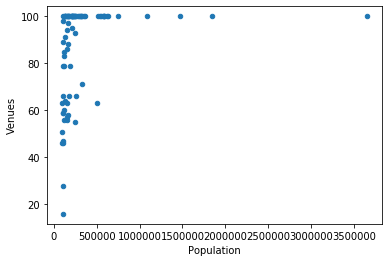

In [15]:
gercities_venues_count.plot.scatter(x='Population', y='Venues')

Of course, bigger cities reach the maximum retrievable count of 100 venues easily.

But one can see, that there is quite a range in the venue count for the smaller cities of population sizes below 500k.

To make this range more distinctable one can plot the population on a logarithmic axis, limited to a population of 500k.

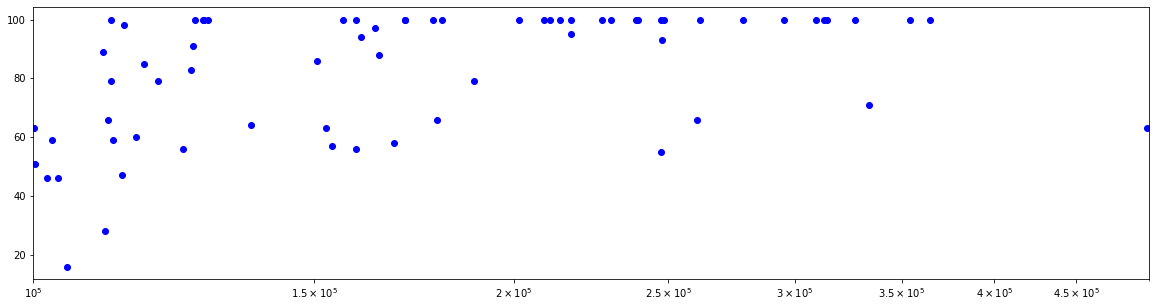

In [16]:
x_data = gercities_venues_count['Population']
y_data = gercities_venues_count['Venues']

fig = plt.figure(figsize=(20,5))
ax = plt.gca(xscale='log', xticks=np.arange(100000,500000,50000), xlim=(100000,500000))
ax.plot(x_data, y_data, 'o', c='blue')
ax.set_xlabel = 'Population'
ax.set_ylabel = 'Venue count'

**Lets look at the cities that have a venue count below 100.**

In [17]:
gercities_venues_count_low = gercities_venues_count.loc[gercities_venues_count['Venues']<100]
gercities_venues_count_low.reset_index(drop=True, inplace=True)

print(gercities_venues_count_low.shape)
gercities_venues_count_low.head()

(36, 6)


,City,Venues,Population,Latitude,Longitude,Venues per Population
0,Bergisch Gladbach,79,111966,50.992930,7.127738,0.000706
1,Bielefeld,71,333786,52.019101,8.531007,0.000213
2,Bottrop,85,117383,51.521581,6.929204,0.000724
3,Bremerhaven,47,113634,53.552226,8.586551,0.000414
4,Chemnitz,55,247237,50.832261,12.925298,0.000222


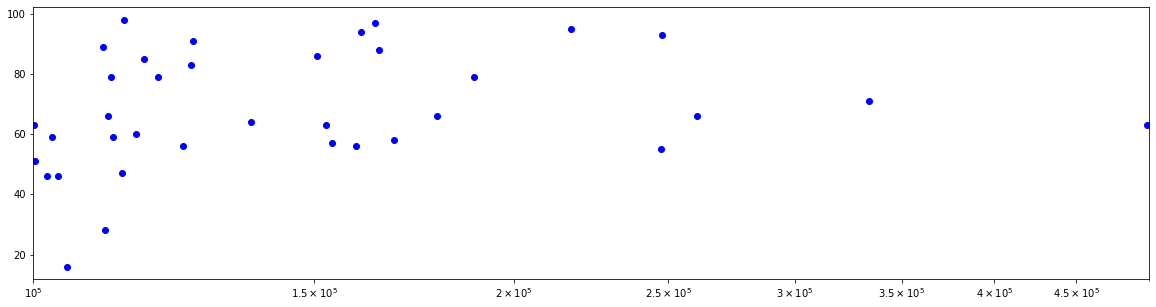

In [18]:
x_data = gercities_venues_count_low['Population']
y_data = gercities_venues_count_low['Venues']

fig = plt.figure(figsize=(20,5))
ax = plt.gca(xscale='log', xticks=np.arange(100000,500000,50000), xlim=(100000,500000))
ax.plot(x_data, y_data, 'o', c='blue')

Let's show them on the map.

In [19]:
# creating the map
map_gercities_venues_count_low = folium.Map(location=[51.351, 10.454], zoom_start=5.5)

# add markers of citis to map
for lat, lng, city, pop, vperpop in zip(gercities_venues_count_low['Latitude'], gercities_venues_count_low['Longitude'], gercities_venues_count_low['City'], gercities_venues_count_low['Population'], gercities_venues_count_low['Venues per Population']):
    label = '{} (Population: {}, Venues per Population: {})'.format(city, pop, vperpop)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_gercities_venues_count_low)

map_gercities_venues_count_low

**Creating the dataframe for these selected cities that will be used for our machine learning algorithms.**

In [20]:
gercities_venues_count_low_grouped = pd.merge(gercities_venues_count_low,
                                              gercities_venues_grouped,
                                              on='City',
                                              how='inner')
gercities_venues_count_low_grouped.head()

,City,Venues,Population,Latitude,Longitude,Venues per Population,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,...,Water Park,Waterfall,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Winery,Yoga Studio,Zoo,Zoo Exhibit
0,Bergisch Gladbach,79,111966,50.992930,7.127738,0.000706,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,Bielefeld,71,333786,52.019101,8.531007,0.000213,0.0,0.0,0.0,0.0,...,0.014085,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.014085,0.0
2,Bottrop,85,117383,51.521581,6.929204,0.000724,0.0,0.0,0.0,0.0,...,0.011765,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,Bremerhaven,47,113634,53.552226,8.586551,0.000414,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.042553,0.0,0.0,0.0,0.0,0.0,0.021277,0.0
4,Chemnitz,55,247237,50.832261,12.925298,0.000222,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
